# Customer Churn using Artificial Neural Network

The goal of this project is to use ANN (Artifical Neural Network) to do binary classification on customer churn data. The dataset consists of 10000 entries with factors such as credit score, location, balance, salary, etc. as well as a 0 or a 1 in the Exited column, with a 0 indicating no churn, and a 1 indicating a churned customer. The goal of our model is to predict whether a customer will remain a customer or not.

The dataset comes from Kaggle. Citation: Kumar, Shubham (2020). Churn Modeling Version 1. Retrieved April 25, 2024 from https://www.kaggle.com/datasets/shubh0799/churn-modelling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's start with loading in the data and taking a look at its basic structure.

In [2]:
df = pd.read_csv('https://drive.usercontent.google.com/u/0/uc?id=1dbVYxN81QnPNkLZxx2z_2z49aku9MLdT&export=download')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

So we can see that the data looks pretty clean. Based off of the descriptive statistics it does not look like we have any outliers. We do have a lot of 0 values for balance. I looked into the data card and it describes balance as "The amount left with them" which I have to say leaves a lot to be assumed. There is not much context about the dataset in general but I assume that this data is customers that have a credit card that is specific to the store. That would have to mean that balance is the amount of debt on the credit card. So 0 values are still valid values that are likely at least somewhat deterministic in churn, which means it is best practice to keep them as 0s.

Now with that out of the way we checked for any NaNs and we do not have any so our data looks clean. Let's make some visualizations to help us understand our data better.

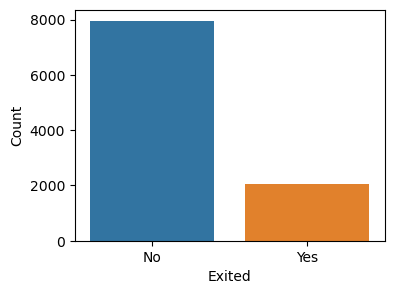

In [7]:
churn_count = df.Exited.value_counts()
plt.figure(figsize=(4, 3))
sns.barplot(x=churn_count.index, y=churn_count.values)
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

It looks like our data is not very balanced, we have many more customers that have not exited. That is something to keep in mind and we will address it later in the notebook.

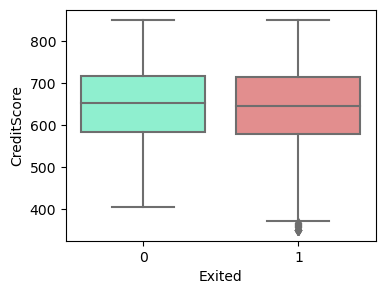

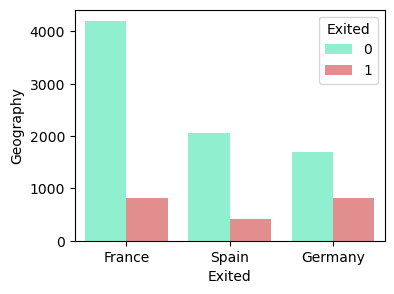

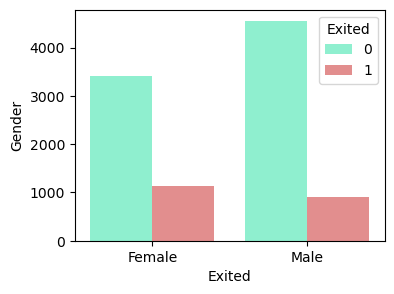

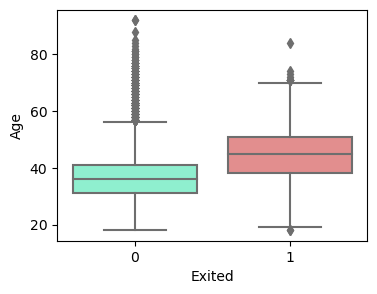

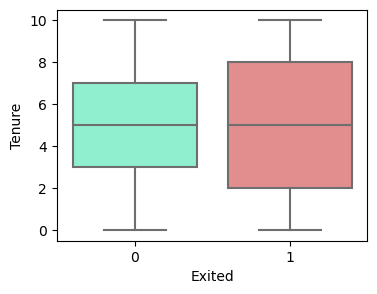

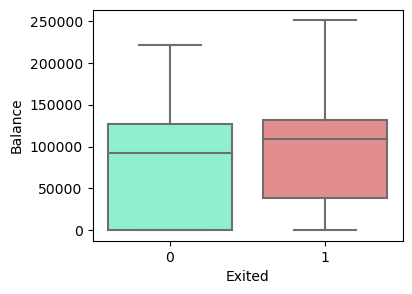

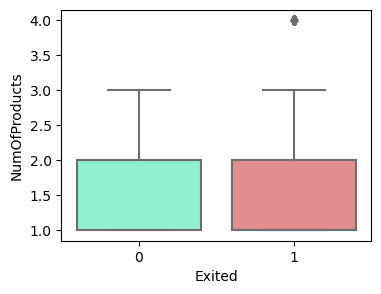

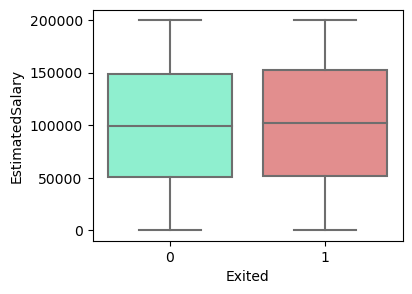

In [8]:
features = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
custom_palette = {0: "aquamarine", 1: "lightcoral"}
sns.set_palette(sns.color_palette(custom_palette.values()))
for feature in features:
    plt.figure(figsize=(4, 3))
    if df[feature].dtype == 'object':
        sns.countplot(x=feature, hue='Exited', data=df)
    else:
        sns.boxplot(x='Exited', y=feature, data=df)
    plt.xlabel('Exited')
    plt.ylabel(feature)
    plt.show()

Now we have a lot of plots to go through. Our first plot indicates that there is not much of a relationship between credit score and churn. One interesting takeaway from that plot though is that we can see a few outlying values with people that have really low credit score exiting. That makes sense because if someone took on a lot of debt and got themselves in a bad financial situation, they are less likely to come back and spend more. Overall I am a bit surprised that there is not a stronger trend with this statistic. The second plot indicates that the ratio of customers who exit is higher in Germany than it is in France or Spain. The third plot shows that there is a slight difference between genders, with males being slightly less likely to exit. In the next plot we see that older folks are slightly more likely to exit. The fifth plot indicates that the median value of tenure(how long the person has been a customer) is about the same, but we see more variance in tenure with those that exit. The balance box plot is quite interesting and suggests that those with a lower balance are less likely to exit and the box goes all the way down to 0. That indicates that there are quite a few people with a balance of 0 who choose to remain customers. The plot for number of products purchased does not seem to indicate a strong relationship with exiting, but we can see some outliers where those with the highest amount of products purchased exited. Our last plot of this series seems to suggest that there is not a strong relationship between salary and churn.

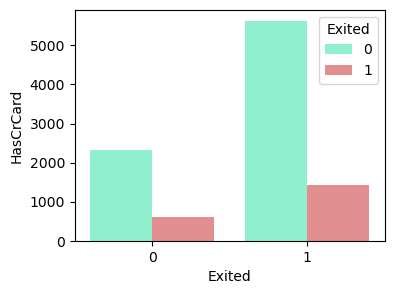

In [9]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.HasCrCard, hue='Exited', data=df)
plt.xlabel('Exited')
plt.ylabel('HasCrCard')
plt.show()

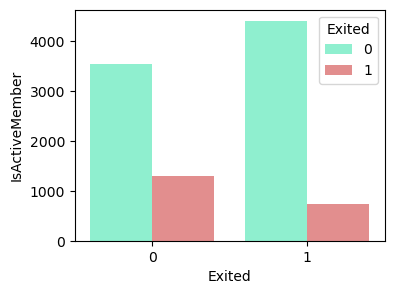

In [10]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.IsActiveMember, hue='Exited', data=df)
plt.xlabel('Exited')
plt.ylabel('IsActiveMember')
plt.show()

Our last two figures here are separate because their dtype was not object, however I thought they were better represented with a count plot(contrary to the function I wrote for the other plots). The first plot of this series suggests that those with a credit card are similarly likely to exit as those without. The second plot indicates that active members are less likely to exit than nonactive members.

In [11]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

The next step here was to drop the columns that do not provide any value to whether a member exits or not, and those were just identifying columns such as row number, customer id, and last name.

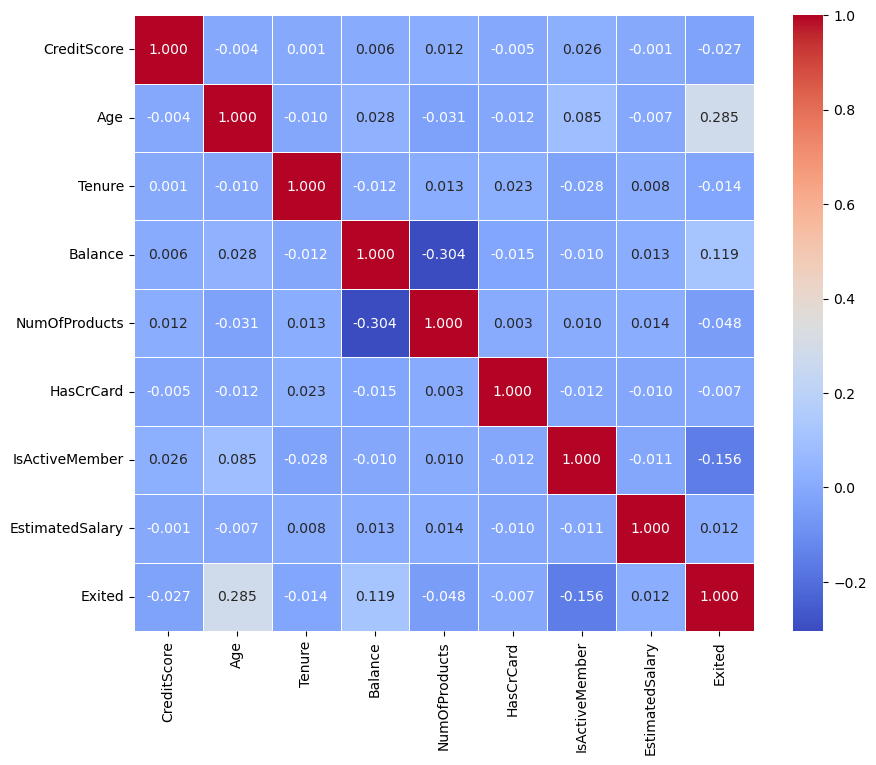

In [12]:
plt.figure(figsize=(10,8))
num_df = df.drop(columns=['Geography', 'Gender'])
corr = num_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f', 
            linewidths=0.5, linecolor='white')
plt.show()

The correlation analysis seems to indicate that there is no strong collinearity between the various numerical factors.

In [13]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Now we have to preprocess our data to get it ready for our model. The first step when we look at the data is to map categorical data to a number.

In [14]:
df['Geography'] = df['Geography'].map({'France' : 0, 'Spain' : 1, 'Germany' : 2})
df['Gender'] = df['Gender'].map({'Female' : 0, 'Male' : 1})

In [15]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,1,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,1,0,43,2,125510.82,1,1,1,79084.10,0


Looks much better, now since the data does not come with a train set and a test set, we will have to split our data.

In [16]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Exited'])
y = df['Exited']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Now that our data is split we can apply a scaler. This part is crucial since right now our data is arbitrary, the model would think that a really high number for salary has more impact than a lower value from a categorical column like geography. So here we use a standard scaler to equalize the weights between the factors.

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

model = Sequential()
model.add(Input(shape=(X_train.shape[1], )))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

So this is our initial model. We start with an input layer in the shape of our train dataset. We then have our first hidden layer which is a dense layer with 64 filters and relu activation. A dropout layer is next to prevent overfitting. Then we have another dense layer with 32 filters and relu activaton as well. Our last layer is the output layer with a filter of 1 and a sigmoid activation which is appropriate for binary classification.

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

y_pred = (model.predict(X_test) > 0.5)

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7089 - loss: 0.5653 - val_accuracy: 0.8106 - val_loss: 0.4287
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.8004 - loss: 0.4573 - val_accuracy: 0.8250 - val_loss: 0.4090
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8160 - loss: 0.4285 - val_accuracy: 0.8381 - val_loss: 0.3933
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.8184 - loss: 0.4162 - val_accuracy: 0.8494 - val_loss: 0.3774
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.8280 - loss: 0.4069 - val_accuracy: 0.8500 - val_loss: 0.3640
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.8402 - loss: 0.3900 - val_accuracy: 0.8575 - val_loss: 0.3516
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.8443 - loss: 0.3849 - val_accuracy: 0.8594 - val_loss: 0.3446
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.8389 - loss: 0.3882 - val_

In [21]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.844
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1571
           1       0.83      0.34      0.49       429

    accuracy                           0.84      2000
   macro avg       0.84      0.66      0.70      2000
weighted avg       0.84      0.84      0.82      2000

[[1541   30]
 [ 282  147]]


So here we can see that the recall score is really low for predicting that the customer will indeed exit. This is likely due to the data being unbalanced and honestly something I should have addressed at the start when we were preforming the EDA. But since we're already here instead of changing all of this let's see how our results change by applying oversampling. The oversampling method I chose is SMOTE-NC because it is one of the best tools for an imbalanced dataset like this one and prevents helps address issues such as overfitting compared to techniques such as duplicating samples. We are using SMOTE-NC as opposed to regular SMOTE because we are dealing with both numerical and categorical values.

In [22]:
from imblearn.over_sampling import SMOTENC

cat_feats = [1, 2, 7, 8]
smote = SMOTENC(categorical_features=cat_feats, random_state=42)
X = df.drop(columns=['Exited'])
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, y_train = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
y_train.value_counts()

Exited
1    6352
0    6352
Name: count, dtype: int64

Now our data is balanced!

In [24]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

y_pred = (model.predict(X_test) > 0.5)

Epoch 1/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.7762 - loss: 0.4715 - val_accuracy: 0.6655 - val_loss: 0.6077
Epoch 2/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.8033 - loss: 0.4278 - val_accuracy: 0.6856 - val_loss: 0.5941
Epoch 3/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.7988 - loss: 0.4329 - val_accuracy: 0.6997 - val_loss: 0.5802
Epoch 4/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.8031 - loss: 0.4287 - val_accuracy: 0.6832 - val_loss: 0.5846
Epoch 5/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.8052 - loss: 0.4310 - val_accuracy: 0.7100 - val_loss: 0.5504
Epoch 6/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.8052 - loss: 0.4370 - val_accuracy: 0.6777 - val_loss: 0.6212
Epoch 7/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.8127 - loss: 0.4157 - val_accuracy: 0.6804 - val_loss: 0.6155
Epoch 8/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.7985 - loss: 0.4391 - 

In [25]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.837
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1611
           1       0.58      0.58      0.58       389

    accuracy                           0.84      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.84      0.84      0.84      2000

[[1449  162]
 [ 164  225]]


So our results are better for sure but we are still struggling to predict the 1s. Let's see if we can change the class weights a bit to help with this.

In [26]:
class_weight = {0: 1, 1: 2}

In [27]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, class_weight=class_weight)

y_pred = (model.predict(X_test) > 0.5)

Epoch 1/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.8027 - loss: 0.5920 - val_accuracy: 0.8017 - val_loss: 0.4244
Epoch 2/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.8068 - loss: 0.5785 - val_accuracy: 0.8221 - val_loss: 0.3939
Epoch 3/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.7944 - loss: 0.5867 - val_accuracy: 0.8323 - val_loss: 0.3859
Epoch 4/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.8043 - loss: 0.5640 - val_accuracy: 0.8261 - val_loss: 0.3891
Epoch 5/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.8019 - loss: 0.5756 - val_accuracy: 0.8445 - val_loss: 0.3695
Epoch 6/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.7926 - loss: 0.5939 - val_accuracy: 0.8414 - val_loss: 0.3615
Epoch 7/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.8036 - loss: 0.5662 - val_accuracy: 0.8343 - val_loss: 0.3851
Epoch 8/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.7987 - loss: 0.5808 - 

In [28]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.8095
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1611
           1       0.51      0.72      0.60       389

    accuracy                           0.81      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.81      0.82      2000

[[1338  273]
 [ 108  281]]


Okay our recall score for 1s is finally at an acceptable level, however in order to increase our recall we had to sacrifice precision. Looks like we have more tuning to do, let's try to adjust the threshold.

In [29]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, class_weight=class_weight)

y_pred = (model.predict(X_test) > 0.6)

Epoch 1/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.8002 - loss: 0.5772 - val_accuracy: 0.8497 - val_loss: 0.3596
Epoch 2/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.8142 - loss: 0.5494 - val_accuracy: 0.8257 - val_loss: 0.3838
Epoch 3/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.8042 - loss: 0.5747 - val_accuracy: 0.8465 - val_loss: 0.3584
Epoch 4/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.8012 - loss: 0.5762 - val_accuracy: 0.8166 - val_loss: 0.4064
Epoch 5/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.8124 - loss: 0.5601 - val_accuracy: 0.8347 - val_loss: 0.3729
Epoch 6/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.8103 - loss: 0.5574 - val_accuracy: 0.8390 - val_loss: 0.3699
Epoch 7/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.8032 - loss: 0.5662 - val_accuracy: 0.8249 - val_loss: 0.3873
Epoch 8/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.8046 - loss: 0.5792 - 

In [30]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.8295
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1611
           1       0.55      0.67      0.60       389

    accuracy                           0.83      2000
   macro avg       0.73      0.77      0.75      2000
weighted avg       0.84      0.83      0.84      2000

[[1400  211]
 [ 130  259]]


Still not great, but I am determined! Let's try to adjust model complexity.

In [31]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], )))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

y_pred = (model.predict(X_test) > 0.6)

Epoch 1/15
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7084 - loss: 0.5737 - val_accuracy: 0.6619 - val_loss: 0.6401
Epoch 2/15
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.7466 - loss: 0.5116 - val_accuracy: 0.6824 - val_loss: 0.5953
Epoch 3/15
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7682 - loss: 0.4808 - val_accuracy: 0.7147 - val_loss: 0.5615
Epoch 4/15
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.7776 - loss: 0.4648 - val_accuracy: 0.7127 - val_loss: 0.5728
Epoch 5/15
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7825 - loss: 0.4637 - val_accuracy: 0.7300 - val_loss: 0.5370
Epoch 6/15
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.7858 - loss: 0.4541 - val_accuracy: 0.7320 - val_loss: 0.5438
Epoch 7/15
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.7999 - loss: 0.4420 - val_accuracy: 0.7336 - val_loss: 0.5291
Epoch 8/15
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.7919 - loss: 0.4435 - va

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.8485
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1611
           1       0.62      0.59      0.60       389

    accuracy                           0.85      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.85      0.85      0.85      2000

[[1469  142]
 [ 161  228]]


So I continued to try to make different changes to the model without adding additional lines to the already extensive notebook. I tried changing optimizers, using different activation functions, adjusting dropout, etc. but I was unable to achieve a score I was happy with. Let's see if we can do better with a Random Forest classifier.

In [34]:
from sklearn.ensemble import RandomForestClassifier

y_train = y_train.values.ravel()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.8265
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1611
           1       0.54      0.68      0.60       389

    accuracy                           0.83      2000
   macro avg       0.73      0.77      0.75      2000
weighted avg       0.84      0.83      0.83      2000

[[1389  222]
 [ 125  264]]


It seems like the Random Forest classifier is having the same issues. Since this is a Kaggle dataset I looked at other people's notebooks and it turns out they were getting similar scores. Sometimes the data just does not allow for the most accurate predictions such as in this case and all we can do is put our best effort to maximize the scores.

# Conclusion

In conclusion, our goal was to classify customer churn based on metrics such as age, income, credit score, etc. Our initial model clearly struggled with a really low recall score of 0.38 for predicting 1s(customers that will churn) so I decided to employ an oversampling technique to try to balance the data for better results. With SMOTE-NC the results were significantly better but still the model struggled in predicting 1s. After some brute force hyperparameter tuning(because I was trying to find a balance rather than maximize just one metric), I managed to find a pretty solid balance between precision and recall for predicting 1s while getting a fairly high accuracy score. The scores were still not as high as one would like them to be but this seems to be a common issue with this particular dataset. Some possible future work to try to improve the model further would be ideas like additional feature engineering as well as ensemble methods.